---
layout:code-post
title: Feed Forward Networks
tags: neural nets
---

In this post / notebook I'm going to move from a single neuron to a small
network of neurons, demonstrating just a bit how the complexity increases.
Initially I will start again by coding things by hand, but then at the end
I will try to recreate results with `PyTorch` as a way to introduce myself
to it. We will stay in the realm of supervised learning of a binary
classification problem, as well.

I am mostly following the neural net chapter from Benjamin and Shalev-Schwartz's
_Understanding Machine Learning_.

Outline:

0. Generating Data
1. Adding neurons
  1. Keeping it linear
  2. Sigmoid function
2. Backpropogation
3. An example
4. Pytorch

## 0. Generating Data

Before we really get going, I'm going to set up some training data. For
this notebook, I'm goign to uniformly generate points in a 10 x 10 square
with the bottom left corner at the origin. The points will be classified
by where the fall with respect to input functions. We'll mostly be using
linear functions to carve up our test space, so we'll create some helper
functions for those as well.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Functions for lines

class SlopeLine():
    """ a line defined by slope and intercept """
    def __init__(self, m, b):
        self.m = m
        self.b = b
        
    def y(self, x):
        return self.m * x + self.b
    
    def x(self, y):
        return (y - self.b) / self.m

def get_slope_line(point_1, point_2):
    """returns slope line object with line determined by the points
    where point_i = (x, y)"""
    
    m = (point_2[1] - point_1[1]) / (point_2[0] - point_1[0])
    b = point_1[1] - m * point_1[0]
    
    return SlopeLine(m, b)

# Functions to generate points
class Inequality():
    """
    given a function f(x) of one variable.
    we will test y < f(x) or y > f(x)
    for a point (x, y)
    """
    def __init__(self, func, ineq_type):
        self.func = func
        
        if ineq_type == '<':
            self.eval = self.less_than
        elif ineq_type == '>':
            self.eval = self.greater_than
        else:
            raise Exception("ineq_type must be '>' or '<'")
        
    def less_than(self, point):
        return point[:,1] < self.func(point[:,0])
    
    def greater_than(self, point):
        return point[:,1] > self.func(point[:,0])
    

def generate_points(n, inequality_lists):
    """ get n points in the 10x10 square classified by
    inequalities.
    
    inequality_lists should be a list of lists of inequalities.
    
    Points are evaluated to the positive class (1) by the
    interior lists if all the inequalities in that list
    are satisfied. Then, if any of the the interior lists
    return true, the point is classified as true.
    
    """
    data_x = np.random.uniform(0, 10, (n, 2))
    
    def evaluate_list(inequality_list):
        
        evals = np.array([ineq.eval(data_x) for ineq in inequality_list]) \
                  .transpose()
        return np.array([all(p) for p in evals])
    
    all_evals = np.array([evaluate_list(il) for il in inequality_lists]) \
                  .transpose()
    
    data_y = np.array([1 if any(p) else -1 for p in all_evals])
    
    data = {
        'x_1': data_x[:,0]
        ,'x_2': data_x[:,1]
        ,'y': data_y
    }
    return pd.DataFrame(data)

## 2. Adding Neurons

A single neuron $v_1$ acts on $k$-dimensional input $x$ by weighting each
component of $x$ as well as the constant 1, adding these weighted
components together, and inputing that into an activation function
$\sigma$. If we write the input as $x' = (x, 1)$ as a column vector,
then the input $a$ to the neuron is $Wx'=a$ where $W$ is an $(k+1)$-dimensional
row vector, i.e., a $1,k+1$-dimensional matrix. Then the output $o$ of the
neuron is $o=\sigma(Wx')$.

Let's add a second neuron $v_2$. It also gets the same input but with
different weights. If we take $W$ to be a $2,k+1$-dimensional matrix,
then $Wx'$ is length 2 vector. Let's now regard $\sigma$ as a function 
which applies the previous activation function to each component of an 
input vector. Then the output of the two neurons is $\sigma(Wx')$, as
before, but we've changed the meaning of the components.

However, we have a problem. We now have two dimensional output when we
are predicting one class. We then add an _output layer_ which consists
of a single neuron that takes in the weighted output of the previous
layer and applies an activation function. So by trying to expand our
neural network from 1 neuron to 2, we naturally were forced to add a
single neuron output layer as well as weights for the outputs of each
of the two neurons. If we consider the inputs as a layer, we
see the the simplest neural network that does not reduce to a single neuron
has one _hidden layer_ of two neurons, an output layer of a single neuron,
and $k+1$ trivial neurons in the _input layer_.

We will write $W^1$ for the $2,k-1$-dimensional weight matrix
from $x'$ to the hidden layer, and $W^2$ for the $1,2$-dimensional
weight matrix (in this case a vector) for the weights going to the output
layer from the hidden layer. The output of the neural network is
$\sigma(W^2\sigma(W^1x'))$. Note that we could change the activation
functions per neuron or per level. In particular, the output layer
might have a distinct activation function from the hidden layers.

Let's set up this simple neural network and see what it can do.

In [3]:
class SimpleNN():
    """neural network with 1 hidden layer and 2 neurons
    
    This class assumes that sigma at each
    layer works on vectors of the appropriate size"""
    
    def __init__(self, w, sigma):
        self.w = w
        self.sigma = sigma
        
    def output(self, x):
        """ we assume that the row vector x already has 1 appended to it"""
        if type(x) == list:
            x = np.array(x)
        
        o_1 = self.sigma[0](np.matmul(self.w[0], x.transpose()))
        return self.sigma[1](np.matmul(self.w[1], o_1)).transpose()
    
def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

### A. Keeping it linear

To keep things very simple, we'll start by having the hidden
layer activation functions linear. The output layer
will have an activation function that does the following:

- conjuction
- disjunction

We'll randomly initialize a neuron and see what it does to points in the
square of side length 20 centered at the origin.

In the [perceptron notebook](https://kevinnowland.com/code/2020/04/03/perceptron.html), we saw that 
individual neurons perform linear separators. Can we interpret what is happening here
as the intersection of two linear separators?

### B. Sigmoid Function

Now let's change the hidden lyaer activation function to be the sigmoid
function 
$$ f(x) = \frac{1}{1 + \exp(-x)}. $$
The output layer will activate using the sign function.

W^1 = 
 [[ 0.93405968  0.0944645   0.94536872]
 [ 0.42963199  0.39545765 -0.56782101]]
W^2 = 
 [[ 0.95254891 -0.98753949]]


/anaconda2/envs/gitpage/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


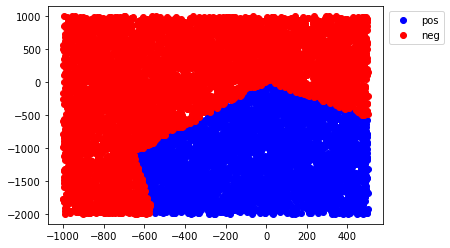

In [4]:
# instantiate neural network
np.random.seed(4)

w = [
    np.random.uniform(-1, 1, (2, 3))
    ,np.random.uniform(-1, 1, (1,2))
]

print('W^1 = \n', w[0])
print('W^2 = \n', w[1])

snn = SimpleNN(w, [sigmoid, np.sign])

# generate random points
test_data = np.ones((10000, 3))

test_data[:,0] = np.random.uniform(-1000, 500, 10000)
test_data[:,1] = np.random.uniform(-2000, 1000, 10000)

# predict
output = snn.output(test_data)

# plot
df = pd.DataFrame({
    'x_1': test_data[:,0]
    ,'x_2': test_data[:,1]
    ,'y': output.flatten()
})

c = df.y == 1

plt.plot(df[c].x_1, df[c].x_2, 'bo', label='pos')
plt.plot(df[~c].x_1, df[~c].x_2, 'ro', label='neg')
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
plt.show()

Can we make sense of this image?

There appear to be three lines governing the behavior. This is convenient, because the
sigmoid function has three sets of behavior. If $|x|$ is small, say $|x| < 4$, then
the sigmoid function is approximately linear with slope 1.
If $|x| > 4$, then sigmoid function is approximately constant, either constantly 1
for $x$ positive, or constantly (very close to but not exactly) zero.

Let $o_1$ be the output of the first neuron in the hidden layer and $o_2$
the output of the second neuron. The output of the neural net is given 
by $\operatorname{sign}{(w_1o_1 + w_2o_2)}$, where we have suppressed the superscript
on the weights. Since $o_i = \sigma(a_i)$ and the sigmoid function is always
positive, if $w_1$ and $w_2$ have the same sign, then the output is determined
by this sign. Therefore we can assume that $w_1$ and $w_2$ have opposite signs.
We'll assume that $w_1>0$ and $w_2<0$.

Let's despense with the degenerate case where $|w_1| = |w_2|$. In practice 
this will not happen, as we will be randomizing the weights and then 
optimizing, and both processes will ensure that this case does not occur. In
theory this is boring. The positive output case occurs then when $o_1 > o_2$ 
and the negative case when $o_1 < o_2$. Since the sigmoid function is 
increasing and $o_i = \sigma(a_i)$ where $a_i$ is the input to neuron $i$, 
this just says we care about $a_1 > a_2$ or vice versa. We might as well have 
replaced the sigmoid function with the identity function as the hidden layer 
activator.

With that taken care of, let's suppose that $|w_1| < |w_2|$ and $w_1 > 0$ while
$w_2 < 0$, which is the case for the picture generated above.
As a reminder, we are looking at the sign of $w_1 o_1 + w_2 o_2$. The dividing line
is $w_1 o_1 + w_2 o_2 = 0$. We can rewrite this as
$$ \left|\frac{w_2}{w_1}\right| = \frac{o_1}{o_2}. $$
Let's like $k = |w_2/w_1| > 1$. Plugging in $o_i = (1 + \exp(-a_i))^{-1}$
and solving for $e^{-a_2}$, one finds that 
$$ e^{-a_2} = ke^{-a_1} + (k-1), $$
such that in $(e^{-a_1}, e^{-a_2})$-coordinates, we have a line with slope
$k>1$ and intercept $k-1>0$. 

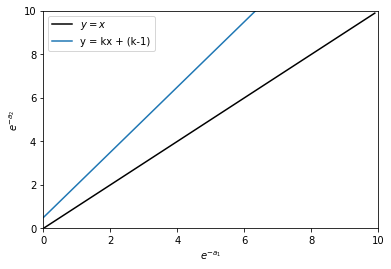

In [5]:
k = 1.5

fig, ax = plt.subplots()

ax.set_xlabel('$e^{-a_1}$')
ax.set_ylabel('$e^{-a_2}$')

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

x = np.array([i/10.0 for i in range(100)])
y = k * x + (k-1)

ax.plot(x, x, color="black", label="$y=x$")
ax.plot(x, y, label="y = kx + (k-1)")

ax.legend()

plt.show()

Now let's consider what happens in terms of $(a_1, a_2)$. The $y$-intercept
at $k-1$ implies that the graph in $a$-coordinates has a horizontal intercept
at $-\log(k-1)$, since $e^{-a_1}$ going to zero implies $a_1$ is going to 
positive infinity and $e^{-a_2}$ is going to the constant $k-1$.

On the other hand, when $a_1=0$, then we have $e^{-a_2} = 2k - 1$, such that
there is always a $a_2$-intercept at $-\log(2k - 1)$. Note that this is always
below the horizontal asymptote.

What about the behavior as $a_1$ tends to $-\infty$? If we rewrite the 
linear equation as
$$ \frac{e^{-a_2}}{e^{-a_1}} = k + \frac{k-1}{e^{-a_1}}, $$
we see that $e^{-a_2} \approx ke^{-a_1}$, such that
$a_2 \approx a_1 - \log k$.

Thus we see that we have three behaviors: when $a_1$ is large, then the 
behavior is that the dividing line is at a constant of $a_2 = -\log(k-1)$. If
$a_1$ is very small, then the dividing line is at $a_2 = a_1 - \log k$. 
Then there is a transition zone, which we need to examine further.

To approximate the transition zone, we will use the tangent line at the point
of maximum curvature. The point of maximum curvature is the point
where $a_2''$ is maximized, i.e., the point where $a_2'''=0$. Since
$$ a_2 = -\log(k e^{-a_1} + (k-1)) $$
According to Wolfram Alpha (what?), the third derivative is zero
at
$$ a_1 = \log\left( \frac{k}{k-1} \right). $$
The point of intersection is therefore
$$ (a_1, a_2) = \left( \log\left(\frac{k}{k-1}\right), -\log(2(k-1)) \right) $$
and the slope is $1/2$. Combining this means that in the transition zone we
approximate the decision boundary with
$$ a_2 = \frac{1}{2}a_1 - \log(2\sqrt{k(k-1)}). $$
The intersection of this line with the horizontal asymptote
$a_2=-\log(k-1)$ is at $a_1 = \log(4k/(k-1))$. The intersection witht the
line $a_1 - \log(k)$ happens at $a_1 = \log(k/4(k-1))$.

Therefore our approximate boundary can be described by
$$
    a_2 = 
    \begin{cases}
        a_1 - \log k & a_1 < \log\left(\frac{k}{k-1}\right) - \log 4, \\
        \frac{1}{2}a_1 - \log(2\sqrt{k(k-1)}) 
            &  \log\left(\frac{k}{k-1}\right) - \log 4 \leq a_1 \leq \log\left(\frac{k}{k-1}\right) + \log 4, \\
        -\log(k-1) & \log\left(\frac{k}{k-1}\right) + \log 4< a_1.
    \end{cases}
$$
Above this line, the output of the neural net will be $-1$, while below it
the ouput will (mostly) be $+1$.

Now, for our situation we have
$$ a_1 \approx 0.934x_1 + 0.094 x_2 + 0.945, \quad  a_2 \approx 0.429x_1 + 0.395 x_2 -0.567. $$

Such that the lines we care about are
$$
\begin{align*}
    x_2 &\approx 1.675 x_1 + 4.907, \\
    x_2 &\approx 0.107 x_1 + 5.689, \\
    x_2 &\approx -1.086 x_1 + 9.790
\end{align*}
$$

/anaconda2/envs/gitpage/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


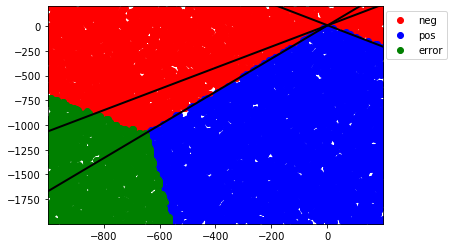

In [24]:
# instantiate neural network
np.random.seed(4)

w = [
    np.random.uniform(-1, 1, (2, 3))
    ,np.random.uniform(-1, 1, (1,2))
]

snn = SimpleNN(w, [sigmoid, np.sign])

# generate random points
test_data = np.ones((10000, 3))

test_data[:,0] = np.random.uniform(-1000, 200, 10000)
test_data[:,1] = np.random.uniform(-2000, 200, 10000)

# predict
output = snn.output(test_data)

# plot
df = pd.DataFrame({
    'x_1': test_data[:,0]
    ,'x_2': test_data[:,1]
    ,'y': output.flatten()
})

c_pos = df.y == 1
c_neg = df.y == -1
c_zero = df.y == 0

fig, ax = plt.subplots()

ax.plot(df[c_neg].x_1, df[c_neg].x_2, 'ro', label='neg')
ax.plot(df[c_pos].x_1, df[c_pos].x_2, 'bo', label='pos')
ax.plot(df[c_zero].x_1, df[c_zero].x_2, 'go', label='error')


ax.set_xlim(min(test_data[:,0]), max(test_data[:,0]))
ax.set_ylim(min(test_data[:,1]), max(test_data[:,1]))

line_1 = SlopeLine(1.675, 4.907)
line_2 = SlopeLine(-1.086, 9.790)
line_3 = SlopeLine(01.07, 5.689)

ax.plot(ax.get_xlim(), line_1.y(np.array(ax.get_xlim())), color='black', linewidth=2)
ax.plot(ax.get_xlim(), line_2.y(np.array(ax.get_xlim())), color='black', linewidth=2)
ax.plot(ax.get_xlim(), line_3.y(np.array(ax.get_xlim())), color='black', linewidth=2)

ax.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
plt.show()

In [17]:
x_1 = -1700
x_2 = -1500

a_1 = w[0][0, 0]*x_1 + w[0][0, 1]*x_2 + w[0][0, 2]
a_2 = w[0][1, 0]*x_1 + w[0][1, 1]*x_2 + w[0][1, 2]

print(a_2)

-1324.1286732934916


The issue is that for both a_1 and a_2 you get an overflow error, so it
calculates both points as zero. So then we get

In [43]:
# this is where it breaks!
sigmoid(-710)

/anaconda2/envs/gitpage/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


0.0

# Here's the more general setup:

Let $\ell_i$ consist of
a layer (list) of neurons $\{v_{i, 0}, \ldots, v_{i, n}\}$.

A feed forward neural network consists of layers of neurons $ell_i$ for 
$i=0, \ldots, T$ such that the neurons in $\ell_t$ feed into those in
$\ell_{t+1}$ only. By convention, if $x$ is $k$-dimensional input, then
$\ell_0$ consists of the $k+1$ neurons $n_i$ such that $n_i$ puts out $x_i$ for
$i=1,\ldots,k$ and $n_{k+1}$ outputs $1$. The $0$th layer is also called the
_input layer_.  The _output layer_ $\ell_T$ to consist of a single 
neuron $v_T$ which aggregates the input from the previous layer into a final
prediction for the input data. The layers $\ell_1, \ldots, \ell_{T-1}$ are the
_hidden layers_. The _width_ of the network is th width of the widest
hidden layer.

Suppose that layer $\ell_{t-1}$ has width $n$ and $\ell_t$ has width $n$.
Let $o_{t-1}$ be the $n$-dimensional output of $\ell_{t-1}$ and let $a_t$
the $m$-dimensional input of $\ell_t$. If $w^t_{i, j}$ is the weight
from $v_{t-1, i}$ to $v_{t, j}$, then it follows that $W^t o_{t-1} = a_t$
where $W^t = (w^t_{i, j})$ is an $m\times n$-dimensional matrix. Two neurons
are not connected if the corresponding weight is 0.

Let $\sigma^t$ be the $m$-dimensional vector of activation functions for $\ell_t$.
Then $o_t = \sigma^t(a_t) = \sigma^t(W^to_{t-1})$.
If each component of each $\sigma^t$ is identical, we will just write $\sigma$
and the meaning will be clear from context.

Note that the smallest neural network which is not equivalent to a single
neuron has 1 hidden layer with 2 neurons. Considering the input layer
and the output layer, this neural network would have $k+4$ neurons:
$k+1$ in the input layer, $2$ in the single hidden layer, and 1 in the output
layer.

The _architecture_ of the network refers to the structure edges between neurons,
which are zero, and which are nonzero, as well as the which activation functions
each neuron has.

## Misc

In [7]:
eye_1 = np.array([
    [2, 5]
    ,[3, 6]
    ,[4, 5]
    ,[3, 4]
    ,[2, 5]
])
eye_2 = eye_1 + [4, 0]
mouth = np.array([[2, 2], [8, 2], [5, 1], [2, 2]])

lines_eye_1 = [get_slope_line(eye_1[i], eye_1[i+1]) for i in range(len(eye_1) - 1)]
lines_eye_2 = [get_slope_line(eye_2[i], eye_2[i+1]) for i in range(len(eye_2) - 1)]
lines_mouth = [get_slope_line(mouth[i], mouth[i+1]) for i in range(len(mouth) - 1)]

ineq_eye_1 = [Inequality(lines_eye_1[0].y, '<'), Inequality(lines_eye_1[1].y, '<'),
              Inequality(lines_eye_1[2].y, '>'), Inequality(lines_eye_1[3].y, '>')]

ineq_eye_2 = [Inequality(lines_eye_2[0].y, '<'), Inequality(lines_eye_2[1].y, '<'),
              Inequality(lines_eye_2[2].y, '>'), Inequality(lines_eye_2[3].y, '>')]

ineq_mouth = [Inequality(lines_mouth[0].y, '<'), Inequality(lines_mouth[1].y, '>'), 
              Inequality(lines_mouth[2].y, '>')]

df = generate_points(10000, [ineq_eye_1, ineq_eye_2, ineq_mouth])

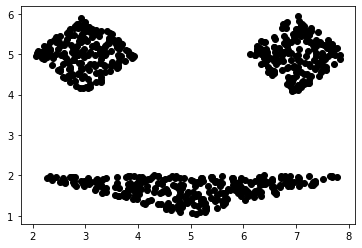

In [8]:
c = df['y'] == 1

plt.plot(df[c].x_1, df[c].x_2, 'ko')
#plt.plot(df[~c].x_1, df[~c].x_2, 'ro')
plt.show()

In [9]:
center = [5, 5]
r = 4

offset = -np.pi / 8 + .00001

points = r * np.array([[np.cos(i * np.pi / 4 + offset), np.sin(i * np.pi / 4 + offset)] for i in range(9)]) + center

In [10]:
inequalities = [[
    Inequality(get_slope_line(points[i], points[i+1]).y, '<' if i < 4 else '>') for i in range(8)
]]

df = generate_points(10000, inequalities)

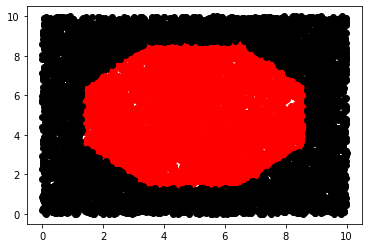

In [11]:
c = df['y'] == 1

plt.plot(df[c].x_1, df[c].x_2, 'ro')
plt.plot(df[~c].x_1, df[~c].x_2, 'ko')
plt.show()